In [1]:
import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def trend_sequence(n, sign, sigma):
    return np.cumsum(np.random.normal(loc=sign * sigma ** 2, scale=sigma, size=n))

def noisy_sin(n, A, sigma, w):
    phi = 2 * np.pi * np.random.random()
    b = np.random.normal(scale=1)
    x = np.linspace(0, 8 * np.pi, n)
    return A * np.sin(2 * np.pi * w * x + phi) + np.random.normal(scale=sigma, size=n) + b

In [2]:
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.datasets import imdb

"""
# IMDB Dataset loading
train, val, test = imdb.load_data(path='imdb.pkl', maxlen=200,
                                  n_words=20000)
trainX, trainY = train
valX, valY = val
testX, testY = test
"""

"\n# IMDB Dataset loading\ntrain, val, test = imdb.load_data(path='imdb.pkl', maxlen=200,\n                                  n_words=20000)\ntrainX, trainY = train\nvalX, valY = val\ntestX, testY = test\n"

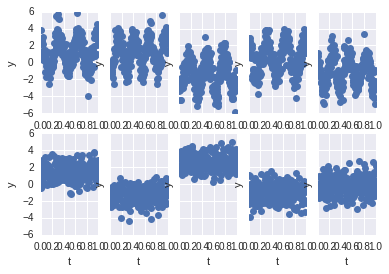

In [3]:
np.random.seed(0)
n = 250
N_train = 5000; N_val = 1000; N_test = 1000; N = N_train + N_val + N_test
train = np.arange(N_train); test = np.arange(N_test) + N_train; val = np.arange(N_val) + N_train + N_test

w_min = 0.02; w_max = 0.2
w = w_min + np.random.random(N) * (w_max - w_min)
A = 2.0; sigma = 1.0
Y = (np.random.random(N) > 0.5).astype('int') # binary: periodic or not
X = np.array([noisy_sin(n, A * y_i, sigma, w_i) for y_i, w_i in zip(Y, w)])
#X = np.array([trend_sequence(n, y_i, sigma) for y_i in Y])
#Y = 1 / ((w_max - w_min) * np.random.random(size=N,) + w_min) # random period
#X = np.array([noisy_sin(n, A, sigma, 1 / y_i) for y_i in Y])

n_plots = 5
fig, ax = plt.subplots(2, n_plots, sharey=True)
for j in range(ax.shape[1]):
    ax[0, j].plot(np.linspace(0, 1, n), X[np.where(Y==1)[0][j]], 'o')
    ax[0, j].set(xlabel="t", ylabel="y")
    ax[1, j].plot(np.linspace(0, 1, n), X[np.where(Y==0)[0][j - n_plots]], 'o')
    ax[1, j].set(xlabel="t", ylabel="y")
#fig, ax = plt.subplots(1, n_plots, sharey=True)
#for j in range(n_plots):
#    ax[j].plot(np.linspace(0, 1, n), X[train[j]], 'o')
#    ax[j].set(xlabel="t", ylabel="y")

# switch to one-hot
#Y = np.c_[Y == 1, Y == -1].astype('float64') #  why float?
#Y = Y.reshape((-1, 1))

In [4]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression()
#model = sklearn.linear_model.LinearRegression()
model.fit(X[train], Y[train])
#print(np.mean((model.predict(X[test].squeeze()) - Y[test]) ** 2))
print(np.mean(model.predict(X[test]) == Y[test]))

0.503


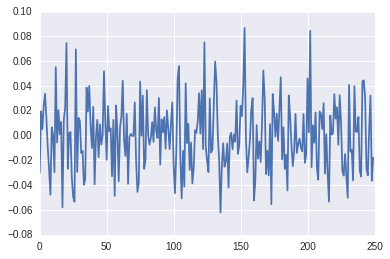

In [5]:
plt.plot(model.coef_[0])

In [6]:
# Data preprocessing
# Sequence padding
trainX = X[train].reshape((-1, n, 1))#pad_sequences(trainX, maxlen=200, value=0.)
testX = X[test].reshape((-1, n, 1))#pad_sequences(testX, maxlen=200, value=0.)
valX = X[val].reshape((-1, n, 1))
# Converting labels to binary vectors
trainY = to_categorical(Y[train], nb_classes=2)
valY = to_categorical(Y[val], nb_classes=2)
testY = to_categorical(Y[test], nb_classes=2)

In [ ]:
%%time
# Network building
tf.set_random_seed(1234)
with tf.Graph().as_default():
    net = tflearn.input_data([None, n, 1])
    net = tflearn.lstm(net, 128, weights_init='normal')
#    net = tflearn.dropout(net, 0.5)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy', learning_rate=5e-4)

    # Training
    model = tflearn.DNN(net, tensorboard_verbose=0)#, clip_gradients=5.0)
    model.fit(trainX, trainY, validation_set=(valX, valY), show_metric=True,
              batch_size=128, n_epoch=int(500 * 120 / N_train))

Training Step: 480  | total loss: 0.18094
| Adam | epoch: 012 | loss: 0.18094 - acc: 0.9430 | val_loss: 0.19412 - val_acc: 0.9186 -- iter: 0000/5000
Training Step: 480  | total loss: 0.18094
| Adam | epoch: 012 | loss: 0.18094 - acc: 0.9430 | val_loss: 0.19412 - val_acc: 0.9186 -- iter: 0000/5000
--
CPU times: user 3min 26s, sys: 25.6 s, total: 3min 52s
Wall time: 2min 36s


In [ ]:
%%time
# switch to one-hot
Y = np.c_[Y == 1, Y == -1].astype('float64') #  why float?
#Y = Y.reshape((-1, 1))

# Parameters
learning_rate = 0.0005
training_iters = 500
batch_size = 128
display_step = 100

# Network Parameters
n_input = 1 # input dimension
n_steps = n # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 2
#n_classes = 1

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
istate = tf.placeholder("float", [None, 2 * n_hidden]) #state & cell => 2x n_hidden
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def RNN(_X, _istate, _weights, _biases):

    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, input_size=n_hidden)#, use_peepholes=True)#, forget_bias=1.0)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, _X, initial_state=_istate)

    # Linear activation
    # Get inner loop last output
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']

pred = RNN(x, istate, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
#cost = tf.reduce_mean(tf.pow(pred - y, 2)) / 2. # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
#accuracy = tf.reduce_mean(tf.pow(pred - y, 2)) / 2.

# Initializing the variables
init = tf.initialize_all_variables()
X_train = X[train].reshape((-1, n_steps, n_input))
X_test = X[test].reshape((-1, n_steps, n_input))

w_hidden_hist = tf.histogram_summary("weights_h", weights['hidden'])
w_out_hist = tf.histogram_summary("weights_o", weights['out'])
b_hidden_hist = tf.histogram_summary("biases_h", biases['hidden'])
b_out_hist = tf.histogram_summary("biases_o", biases['out'])
y_hist = tf.histogram_summary("y", y)
accuracy_summary = tf.scalar_summary("accuracy", accuracy)
merged = tf.merge_all_summaries()

# Launch the graph
tf.set_random_seed(1234)
with tf.Session() as sess, tf.Graph().as_default():
    sess.run(init)
    writer = tf.train.SummaryWriter("/tmp/tflearn_logs/tf", sess.graph_def)
    for step in range(training_iters):
        inds = (np.arange(batch_size) + step * batch_size) % N_train
        batch_xs = X[train[inds]]
        batch_ys = Y[train[inds]]
        batch_xs = batch_xs.reshape((batch_size, n_steps, n_input))
        if step % display_step == 0:  # Record summary data, and the accuracy
            summary_str, acc, loss = sess.run([merged, accuracy, cost], feed_dict={x: batch_xs, y: batch_ys,
                                    istate: np.zeros((batch_size, 2*n_hidden))})
            writer.add_summary(summary_str, step)
            print("Iter {:4d}".format(step) 
                  + ", Minibatch Loss= " + "{:.6f}".format(loss)
                  + ", Training Accuracy= " + "{:.5f}".format(
                    sess.run(accuracy, feed_dict={x: X_train, y: Y[train], istate: np.zeros((N_train, 2*n_hidden))}))
                  + ", Test Accuracy={:.6f}".format(
                    sess.run(accuracy, feed_dict={x: X_test, y: Y[test], istate: np.zeros((N_test, 2*n_hidden))})))
        else:
            # Fit training using batch data
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys,
                                           istate: np.zeros((batch_size, 2*n_hidden))})
    print("Optimization Finished!")
    print("Testing Accuracy= ", sess.run(accuracy, feed_dict={x: X_test, y: Y[test],
                                                         istate: np.zeros((N_test, 2*n_hidden))}))

Iter    0, Minibatch Loss= 1.819961, Training Accuracy= 0.29820, Test Accuracy=0.314000
Iter  100, Minibatch Loss= 0.120279, Training Accuracy= 0.99820, Test Accuracy=0.998000
Iter  200, Minibatch Loss= 0.043916, Training Accuracy= 0.99200, Test Accuracy=0.992000
Iter  300, Minibatch Loss= 0.053067, Training Accuracy= 0.98320, Test Accuracy=0.983000
